In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2, json, torch, os, re

import util, constants, draw, cam, model, parse_alphapose

np.random.seed(0)
torch.manual_seed(0)

VID_ROOT = '/home/akarshkumar0101/Insync/akarshkumar0101@gmail.com/Google Drive/nba-3d-data/harden/'
DATA_ROOT = '/home/akarshkumar0101/Insync/akarshkumar0101@gmail.com/Google Drive/nba-3d-data/'

img_shape_yx = plt.imread(VID_ROOT+'/all_views/frame_00001.png').shape[:2];img_shape_xy = img_shape_yx[::-1]

uf_mat_int_default = cam.get_intrinsic_mat_default()
uf_mat_int = cam.get_intrinsic_mat_for_img_shape(img_shape_xy)

print(f'img_shape_xy: {img_shape_xy}')

img_shape_xy: (1280, 720)


# Convention Used
## World Coordinates
-Z is direction of gravity.
# Camera Coordinates
+Z is looking forward.
+X is looking left.
+Y is looking up.


We know that $x_i = x_cfm_x/z_c + u_0$.
We instead define $(f_x, f_y) = f(m_x, m_y)$.

We will let $u_0=v_0=0$

We will crop the image in $x$ and $y$ at $(-1, 1)$ and the $f_x, f_y$ will determine how "fast or slow" the x coordinate will grow and shrink and adjust to our cropping window.
We will display the cropping window with whatever height x width we want to.

# Model

## Model Coordinates Model

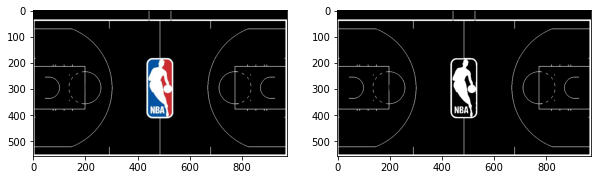

In [2]:
court_img, court_bin = model.load_model_img(DATA_ROOT)
court_img = (court_img*255/court_img.max()).astype(np.uint8)
plt.figure(figsize=(10,3))
plt.subplot(121);plt.imshow(court_img)
plt.subplot(122);plt.imshow(court_bin, cmap='gray')
plt.show()

## World Coordinates Model

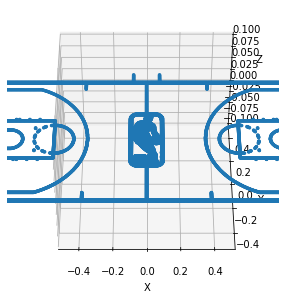

In [3]:
mat_model = model.get_mat_model(model.load_model_corners(DATA_ROOT))
X_m = model.get_model(DATA_ROOT)
X_w = model.calc_model_world_coordinates(DATA_ROOT)

plt.figure(figsize=(10,5))
ax = plt.subplot(projection='3d')
ax.scatter3D(X_w[:, 0], X_w[:, 1], X_w[:, 2], marker='.')
ax.set_xlabel('X');ax.set_ylabel('Y');ax.set_zlabel('Z')
ax.set_xlim(-.5,.5);ax.set_ylim(-.5,.5);ax.set_zlim(-.1, .1)
ax.view_init(45,-90)
plt.show()

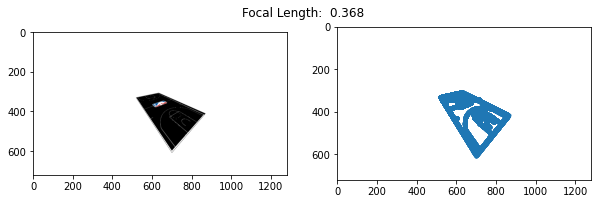

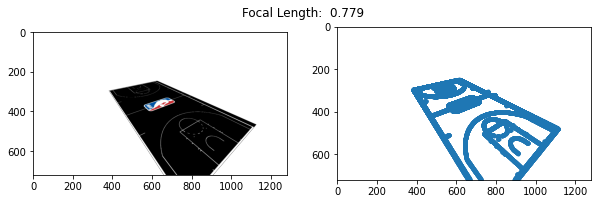

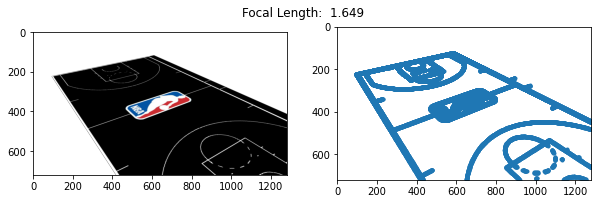

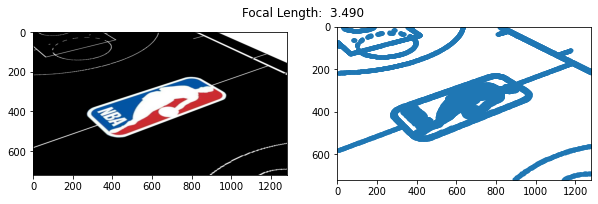

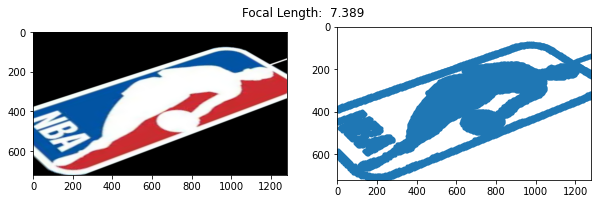

In [4]:
dofs_cam = cam.calc_dofs_cam(torch.tensor([1,-.7,.7]), torch.zeros(3), torch.zeros(1)).repeat(5, 1)
dofs_f = torch.linspace(-1, 2, steps=5)
dofs_cam[:, 6] = dofs_f
imgs = cam.calc_perspective_image(court_img, dofs_cam, mat_model, img_shape_xy)
X_i , viz_mask = cam.project_to_cam(X_w, dofs_cam, img_shape_xy)

for imgs_i, X_i_i, viz_mask_i, dofs_f_i in zip(imgs, X_i, viz_mask, dofs_f):
    X_i_i = X_i_i[viz_mask_i]
    draw.plt_figure_aspect_ratio((img_shape_xy[0]*2, img_shape_xy[1]), width=10)
    plt.subplot(1, 2, 1)
    plt.imshow(imgs_i)
    plt.subplot(1, 2, 2)
    plt.scatter(X_i_i[:, 0], X_i_i[:, 1], marker='.')
    draw.set_img_bounds(img_shape_xy)
    plt.suptitle(f'Focal Length: {np.e**dofs_f_i: 0.03f}')

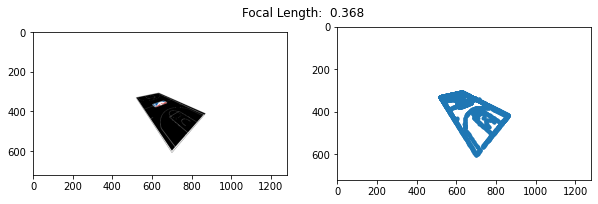

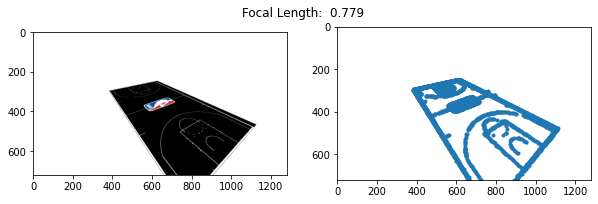

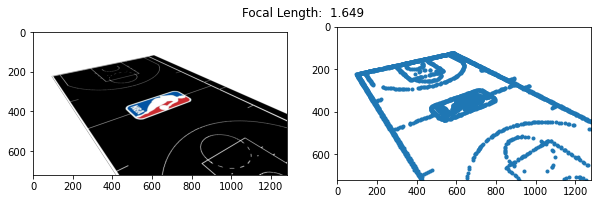

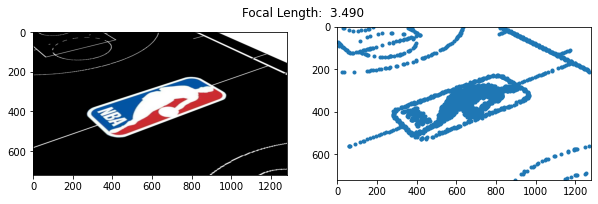

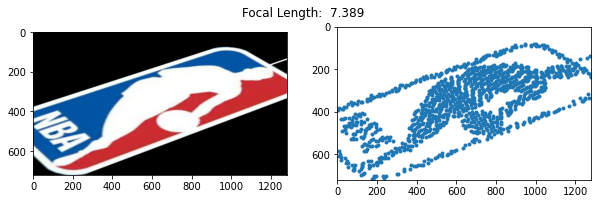

In [5]:
for i, dofs_f in enumerate(torch.linspace(-1, 2, steps=5)):
    draw.plt_figure_aspect_ratio((img_shape_xy[0]*2, img_shape_xy[1]), width=10)
    dofs_cam = cam.calc_dofs_cam(torch.tensor([1,-.7,.7]), torch.zeros(3), dofs_f[None])
    plt.subplot(1, 2, 1)
    plt.imshow(cam.calc_perspective_image(court_img, dofs_cam, mat_model, img_shape_xy))
    plt.subplot(1, 2, 2)
    draw.show_cam_view(torch.from_numpy(X_w[::10]).float(), dofs_cam, img_shape_xy)
    plt.suptitle(f'Focal Length: {np.e**dofs_f: 0.03f}')
    plt.show()

In [14]:
# def generate_random_views(*shape):
#     r = 1+.2*torch.randn(shape)
#     theta = torch.rand(shape)*2*np.pi
#     x,y  = r*torch.cos(theta), r*torch.sin(theta)
#     z = 0.3+1.*torch.randn(shape).abs()
#     dofs_f = (torch.rand(*shape, 2)*(1.6--0.5) - 0.5)
#     x = torch.stack([x,y,z], dim=-1)
#     pts_to = 0.3*torch.randn_like(x)
    
#     dofs_cam = cam.calc_dofs_cam(x,pts_to, dofs_f)
#     return dofs_cam, pts_to

# X sould be of shape (..., 7) and be from a standard multivariate gaussian
def gaussian2cam(X):
    r = .4+.8*torch.sigmoid(X[..., 0])
    theta = 2*np.pi*X[..., 1]
    z = .4+.3*X[..., 2].abs()
    x, y = r*torch.cos(theta), r*torch.sin(theta)
    pos = torch.stack([x,y,z], dim=-1)
    
    px, py, pz = -.6+.2*X[..., 3], .2*X[..., 4], .1*X[..., 5].abs()
    pts_to = torch.stack([px, py, pz], dim=-1)
    
    
    logfx = 0.5*X[..., [6]].abs()
    
    dofs_cam = cam.calc_dofs_cam(pos, pts_to, logfx)
    
    return dofs_cam, pts_to

In [127]:
views_court = [[0,-90], [90, -90], [25, -135]]
region_court = [[-.7,.7], [-.7, .7], [0, .7]]

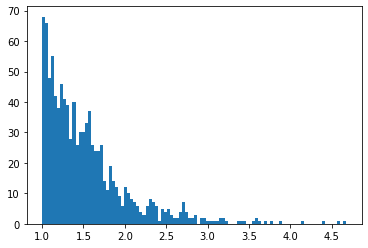

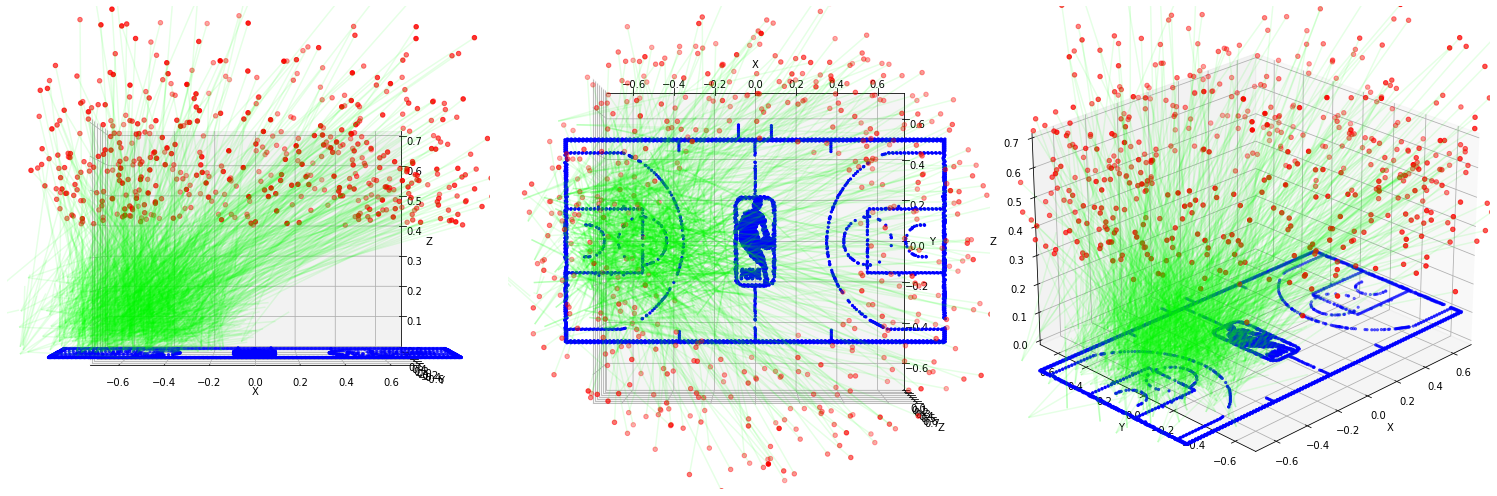

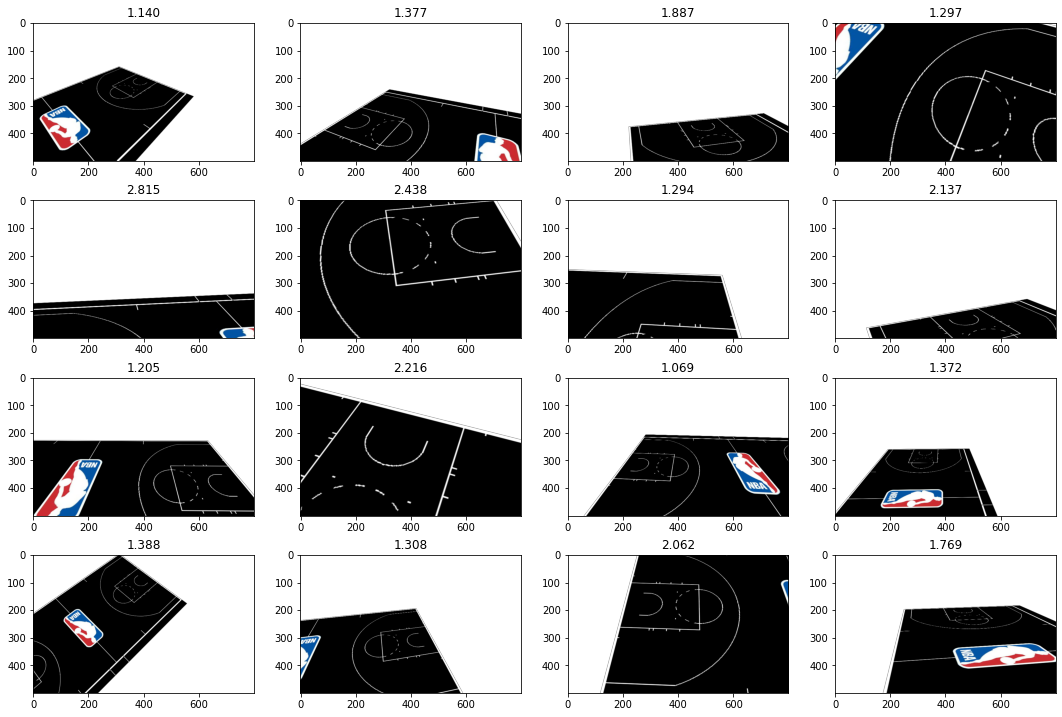

In [128]:
x = torch.distributions.MultivariateNormal(torch.zeros(8), torch.eye(8)).sample((1000,))
dofs_cams, pts_to = gaussian2cam(x)

plt.hist((np.e**dofs_cams[:, 6]).numpy(), bins=100)
plt.show()

x = torch.distributions.MultivariateNormal(torch.zeros(8), torch.eye(8)).sample((500,))
dofs_cams, pts_to = gaussian2cam(x)

for ax in draw.multi_view(views_court, region_court)[0]:
    ax.scatter3D(X_w[::10, 0], X_w[::10, 1], X_w[::10, 2], marker='.', color='b')
    ax.scatter3D(*dofs_cams[:, :3].transpose(0,1), color='r')
    ax.quiver3D(*dofs_cams[:, :3].transpose(0,1), 
                *(pts_to-dofs_cams[:, :3]).transpose(0,1), color=[0., 1., 0., 0.1])
    
plt.figure(figsize=(15, 10))
for i in range(16):
    plt.subplot(4,4,i+1)
    dofs_cam = dofs_cams[i].clone()
#     show_cam_view(X_w[::10], dofs_cam, default_rect)
    plt.imshow(calc_perspective_image(court_img, dofs_cam, (800, 500)))
    plt.title(f'{np.e**dofs_cam[6].item():0.03f}')
plt.tight_layout()


In [34]:
# dofs_cams, pts_to = generate_random_views(500)
# for ax in draw.multi_view(views_court, region_court)[0]:
#     ax.scatter3D(*X_w[::10].transpose(0,1), marker='.', color='b')
#     ax.scatter3D(*dofs_cams[:, :3].transpose(0,1), color='r')
#     ax.quiver3D(*dofs_cams[:, :3].transpose(0,1), 
#                 *(pts_to-dofs_cams[:, :3]).transpose(0,1), color=[0., 1., 0., 0.1])
    
# plt.figure(figsize=(15, 10))
# for i in range(16):
#     plt.subplot(4,4,i+1)
#     dofs_cam = dofs_cams[i].clone()
#     draw.show_cam_view(X_w[::10], dofs_cam)
#     plt.title(f'fx: {np.e**dofs_cam[6].item():1.2f}, fy: {np.e**dofs_cam[7].item():1.2f}')


In [46]:
x = torch.distributions.MultivariateNormal(torch.zeros(8), torch.eye(8)).sample()
dofs_cam, pts_to = gaussian2cam(x)

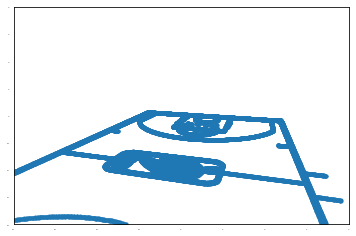

In [47]:
draw.show_cam_view(X_w, dofs_cam)